In [1]:
import random
import time
import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Sampler
import torchvision.datasets as datasets

In [2]:
data_directory = './'

In [3]:
torchvision.datasets.Flowers102(root=f'{data_directory}', download=True)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

Dataset Flowers102
    Number of datapoints: 1020
    Root location: ./
    split=train

In [4]:
class TaskSampler(Sampler):
    
    def __init__(self, dataset, n_way, k_shot, n_query, n_tasks):
        super().__init__(data_source=None)
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_tasks = n_tasks
        self.n_query = n_query
        
        self.items_per_label = {}
        
        for item, label in enumerate(dataset.get_labels()):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]
                
    def __len__(self):
        return self.n_tasks
    
    def __iter__(self):
        for task in range(self.n_tasks):
            yield torch.cat(
                [
                    torch.Tensor(random.sample(self.items_per_label[label], self.k_shot + self.n_query)).type(torch.int)
                    
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            ).tolist()
            
    def collate_fn(self, input_data):
        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.k_shot + self.n_query, *all_images.shape[1:])
        )

        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.k_shot + self.n_query))

        support_images = all_images[:, : self.k_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.k_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.k_shot].flatten()
        query_labels = all_labels[:, self.k_shot :].flatten()

        return support_images, support_labels, query_images, query_labels, true_class_ids


In [5]:
class MatchingNetwork(torch.nn.Module):
    
    def __init__(self, backbone=None, image_size=224, use_full_contextual_embedding=True) -> None:
        super().__init__()
        
        self.use_full_contextual_embedding = use_full_contextual_embedding
        
        self.backbone = backbone
        
        if self.backbone is None:
            self.backbone = self.get_backbone()
        
        self.feature_size = self.get_output_shape(self.backbone, image_size)[0]
        
        self.support_encoder = torch.nn.LSTM(
            input_size=self.feature_size,
            hidden_size=self.feature_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        
        self.query_encoder = torch.nn.LSTMCell(self.feature_size * 2, self.feature_size)
        
        self.contextualized_support_features = None
        self.one_hot_support_labels = None
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    def get_backbone(self):
        backbone = torchvision.models.resnet18(pretrained=True)
        backbone.fc = torch.nn.Flatten()
        return backbone
                
    def encode_support_set(self, support_images, support_labels):

        support_features = self.backbone(support_images)
        
        if self.use_full_contextual_embedding:
            hidden_state = self.support_encoder(support_features.unsqueeze(0))[0].squeeze(0)
            self.contextualized_support_features = support_features + hidden_state[:, : self.feature_size] + hidden_state[:, self.feature_size :]
            
        else:
            self.contextualized_support_features = support_features

        self.one_hot_support_labels = torch.nn.functional.one_hot(support_labels).float()

    def encode_query_features(self, query_set):
        
        query_features = self.backbone(query_set)

        if not self.use_full_contextual_embedding:
            return query_features
        
        hidden_state = query_features
        cell_state = torch.zeros_like(query_features)

        for _ in range(len(self.contextualized_support_features)):
            attention = self.softmax(
                hidden_state.mm(self.contextualized_support_features.T)
            )
            read_out = attention.mm(self.contextualized_support_features)
            lstm_input = torch.cat((query_features, read_out), 1)

            hidden_state, cell_state = self.query_encoder(
                lstm_input, (hidden_state, cell_state)
            )
            hidden_state = hidden_state + query_features

        return hidden_state
        
    def get_output_shape(self, model, image_size):
        x = torch.randn(1, 3, image_size, image_size)
        out = model(x)
        return out.shape[1:]
    
    def forward(self, support_images, support_labels, query_images):
        
        self.encode_support_set(support_images, support_labels)
        
        contextualized_query_features = self.encode_query_features(
            query_images
        )
        
        similarity_matrix = self.softmax(
            contextualized_query_features.mm(
                torch.nn.functional.normalize(self.contextualized_support_features).T
            )
        )
                
        log_probabilities = (
            similarity_matrix.mm(self.one_hot_support_labels) + 1e-6
        ).log()
        
        return log_probabilities

In [6]:
class PrototypicalNetwork(torch.nn.Module):
    def __init__(self, backbone=None):
        super().__init__()
        self.backbone = backbone
        
        if(self.backbone == None):
            self.backbone = self.get_backbone()
            
    def get_backbone(self):
        backbone = torchvision.models.resnet18(pretrained=True)
        backbone.fc = torch.nn.Flatten()
        return backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [7]:
class EnsembleFSL(torch.nn.Module):
    def __init__(self, n_way=5, num_estimators=2):
        super().__init__()
        self.n_way = n_way
        self.matching_network = MatchingNetwork()
        self.prototypical_network = PrototypicalNetwork()
        
        self.combinational_layer = torch.nn.Sequential(
            torch.nn.Linear(2, 1),
        )
    
    
    def forward(self, support_images, support_labels, query_images):
        matching_net_out = self.matching_network(support_images, support_labels, query_images)
        prototypical_net_out = self.prototypical_network(support_images, support_labels, query_images)
        
        distances = torch.zeros_like(matching_net_out)

        for col in range(self.n_way):
            req_match_out = matching_net_out[:, col:col+1]
            req_proto_out = prototypical_net_out[:, col:col+1]
            concat_out = torch.concat((req_match_out, req_proto_out), dim=1)
            distances[:, col:col+1] = self.combinational_layer(concat_out)
            
        return distances

In [8]:
image_size = 224

n_way = 5
k_shot = 3
n_query = 5
n_tasks = 100
n_epochs = 10
n_train_tasks = 100
n_val_tasks = 100
n_test_tasks = 1000

In [9]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((image_size, image_size)),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]
)


In [10]:
training_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='train', transform=transform)
validation_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='val', transform=transform)
test_set = torchvision.datasets.Flowers102(root=f'{data_directory}', split='test', transform=transform)

print(f'Length of training data: {len(training_set)}')
print(f'Length of validation data: {len(validation_set)}')
print(f'Length of test data: {len(test_set)}')

Length of training data: 1020
Length of validation data: 1020
Length of test data: 6149


In [11]:
training_set.get_labels = lambda: [
    instance for instance in training_set._labels
]

validation_set.get_labels = lambda: [
    instance for instance in validation_set._labels
]

test_set.get_labels = lambda: [
    instance for instance in test_set._labels
]

In [12]:
train_sampler = TaskSampler(training_set, n_way, k_shot, n_query, n_train_tasks)
validation_sampler = TaskSampler(validation_set, n_way, k_shot, n_query, n_val_tasks)
test_sampler = TaskSampler(test_set, n_way, k_shot, n_query, n_test_tasks)

In [13]:
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.collate_fn,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_sampler=validation_sampler,
    collate_fn=validation_sampler.collate_fn,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=test_sampler.collate_fn,
)

In [14]:
def evaluate_model(model, criterion, data_loader):
    
    model.eval()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    start_time = time.time()
    
    for support_images, support_labels, query_images, query_labels, _ in tqdm.tqdm(data_loader):
        
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        scores = model(support_images, support_labels, query_images)

        loss = criterion(scores, query_labels)

        running_loss += loss.item()
        total += query_labels.shape[0]
        _, preds = torch.max(scores, 1)
        running_correct += torch.sum(preds == query_labels).item()

    end_time = time.time()
    
    print(f'Loss: {running_loss / len(data_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
    
    return running_loss / len(data_loader), running_correct / total

In [15]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=100):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    total_time = 0.0
    
    for epoch in range(num_epochs):
        
        model.train()
        
        running_loss = 0.0
        running_correct = 0
        total = 0
        
        start_time = time.time()
        for support_images, support_labels, query_images, query_labels, _ in tqdm.tqdm(train_loader):
            support_images = support_images.to(device)
            support_labels = support_labels.to(device)
            query_images = query_images.to(device)
            query_labels = query_labels.to(device)
            
            optimizer.zero_grad()
            
            scores = model(support_images, support_labels, query_images)
            
            loss = criterion(scores, query_labels)
            
            running_loss += loss.item()
            total += query_labels.shape[0]
            _, preds = torch.max(scores, 1)
            running_correct += torch.sum(preds == query_labels).item()
            
            loss.backward()
            optimizer.step()
         
        end_time = time.time()
        
        scheduler.step()
        
        print(f'Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {running_correct / total}, Time: {(end_time - start_time):.4f}s')
        
        total_time += end_time - start_time
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(running_correct / total)
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
    print(f'Average Training Time: {total_time / num_epochs}')
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [16]:
model = EnsembleFSL(n_way=n_way)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [18]:
history = train(model, criterion, optimizer, lr_scheduler, train_loader, validation_loader, num_epochs=n_epochs)

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Epoch: 1, Loss: 0.12360803078860044, Accuracy: 0.9768, Time: 56.5800s


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Loss: 0.129912679749541, Accuracy: 0.9616, Time: 39.5712s


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch: 2, Loss: 0.020189111468498597, Accuracy: 0.9964, Time: 50.6362s


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Loss: 0.12214193768682889, Accuracy: 0.9576, Time: 39.6408s


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch: 3, Loss: 0.021201243858085944, Accuracy: 0.9944, Time: 50.6434s


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Loss: 0.08740959310671315, Accuracy: 0.9736, Time: 39.4406s


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


Epoch: 4, Loss: 0.013427466713474133, Accuracy: 0.9972, Time: 51.0931s


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Loss: 0.08375683372374625, Accuracy: 0.9724, Time: 39.4615s


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


Epoch: 5, Loss: 0.014117616275907494, Accuracy: 0.998, Time: 50.7525s


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


Loss: 0.09398758865427226, Accuracy: 0.9692, Time: 39.3628s


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch: 6, Loss: 0.013097633771249093, Accuracy: 0.998, Time: 50.4055s


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Loss: 0.08163442609889898, Accuracy: 0.9752, Time: 39.4929s


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Epoch: 7, Loss: 0.013030349751934409, Accuracy: 0.9984, Time: 50.1277s


100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Loss: 0.11289227491710335, Accuracy: 0.9604, Time: 39.1754s


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


Epoch: 8, Loss: 0.011691083113546483, Accuracy: 1.0, Time: 50.0995s


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Loss: 0.09129221619456075, Accuracy: 0.9704, Time: 39.5899s


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Epoch: 9, Loss: 0.012237589505384677, Accuracy: 0.9984, Time: 50.2332s


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Loss: 0.09194326207274571, Accuracy: 0.9752, Time: 39.1470s


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Epoch: 10, Loss: 0.011807904837769456, Accuracy: 0.9996, Time: 50.5928s


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]

Loss: 0.08022500608116388, Accuracy: 0.976, Time: 39.1236s
Average Training Time: 51.11639800071716


In [19]:
train_loss, train_acc, val_loss, val_acc = history

In [20]:
def plot_curve(train_history, val_history, title='Model Accuracy', ylabel='Accuracy', legend_loc='upper left'):
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc=legend_loc)
    
    plt.show()

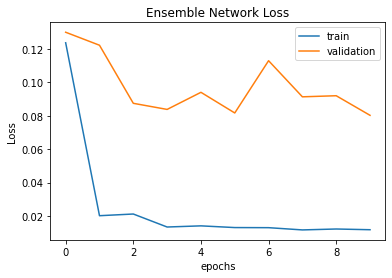

In [21]:
plot_curve(train_loss, val_loss, title='Ensemble Network Loss', ylabel='Loss', legend_loc='upper right')

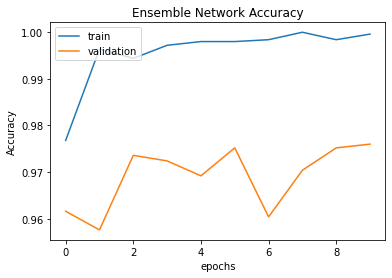

In [22]:
plot_curve(train_acc, val_acc, title='Ensemble Network Accuracy', ylabel='Accuracy', legend_loc='upper left')

In [23]:
print('Train: ', end='')
evaluate_model(model, criterion, train_loader)

print('Validation: ', end='')
evaluate_model(model, criterion, validation_loader)

print('Test: ', end='')
evaluate_model(model, criterion, test_loader);

Train: 

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Loss: 0.013166400416885153, Accuracy: 0.9984, Time: 39.8126s
Validation: 

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Loss: 0.09996235418133438, Accuracy: 0.9692, Time: 39.6218s
Test: 

100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]

Loss: 0.09988391173735726, Accuracy: 0.9682, Time: 395.7740s


In [24]:
torch.save(model.state_dict(), "ensemble_network_episodic.pt")

In [25]:
print(model.combinational_layer[0].weight)
print(model.combinational_layer[0].bias)

Parameter containing:
tensor([[0.3852, 0.3575]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.6859], device='cuda:0', requires_grad=True)
